In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
%ls '../input/nlp-getting-started/'

sample_submission.csv  test.csv  train.csv


### Load Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import re
import string
import emoji
import pickle
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.layers import Embedding, Dropout
from tensorflow.keras.preprocessing.sequence  import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.tree import Tree

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load Data

In [5]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")

In [6]:
print("The number of rows and columns in train data is ", train.shape)
print("The number of rows and columns in test data is ", test.shape)

The number of rows and columns in train data is  (7613, 5)
The number of rows and columns in test data is  (3263, 4)


In [7]:
# Count of positive and negative target in train data
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

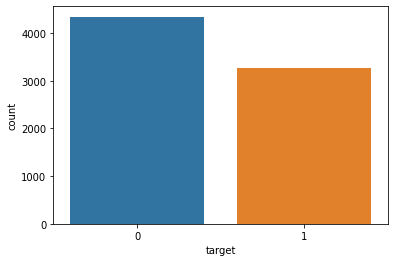

In [8]:
sns.countplot(train['target'], data=train )

In [9]:
# Check for null values in train data
train.isnull().sum()/len(train)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [10]:
# Check for null values in test data
test.isnull().sum()/len(train)

id          0.000000
keyword     0.003415
location    0.145146
text        0.000000
dtype: float64

1. Around 33% of location values are missing from train data. So lets drop Location feature.
2. Keyword are words picked from the tweet text. So we can drop keyword also.

In [11]:
train = train.drop(['location','keyword'], axis=1)
test  = test.drop(['location','keyword'], axis=1)

In [12]:
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


### Data Preprocessing

In [13]:
# Lets have a look at sample tweet
train['text'].iloc[6]

'#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'

In [14]:
def clean_text(text):
  # Delete all the tags like "< anyword >"
  text = re.sub("\<([^)]+)\>", "", text)

  # Delet data present in brackets
  text = re.sub("\(([^)]+)\)", "", text)
  text = re.sub("\[([^)]+)\]", "", text)

  text = re.sub(r'@[A-Za-z0-9_]+','',text)
  text = re.sub('#','', text)

  # Remove all the newlines('\n'), tabs('\t'), "-", "\".
  text = re.sub("\n", "",text)
  text = re.sub("\t", "",text)
  text = re.sub("-", "",text)

  #Decontraction
  # specific
  text = re.sub(r"won\'t", "will not", text)
  text = re.sub(r"can\'t", "can not", text)

  # general
  text = re.sub(r"n\'t", " not", text)
  text = re.sub(r"\'re", " are", text)
  text = re.sub(r"\'s", " is", text)
  text = re.sub(r"\'d", " would", text)
  text = re.sub(r"\'ll", " will", text)
  text = re.sub(r"\'t", " not", text)
  text = re.sub(r"\'ve", " have", text)
  text = re.sub(r"\'m", " am", text)
  

  #Replace all the digits with space
  text = re.sub("\d", "", text)
  
  # Remove emojis
  text = re.sub(emoji.get_emoji_regexp(), r"", text)

  #Remove URLSs
  text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','',text)
  text = re.sub(r"https?://\S+|www\.\S+","",text)

  # Convert all the words into lower case and lowe case and remove the words which are greater than or equal to 15 or less than or equal to 2.
  text = " ".join([e.lower() for e in text.split(" ") if (len(e)>2 and len(e)<15)])
  text = text.strip()

  return text


In [15]:
#Function to remove punctuation
def remove_punc(text):
  # define punctuation
  punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  new_text = ""
  for char in text:
    if char not in punctuations:
      new_text = new_text + char

  return new_text

In [16]:
# Function to remove stopwords from text
from nltk.corpus import stopwords
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  new_text = ""

  for word in text.split():
    if word not in stop_words:
      new_text = new_text+" "+word
  return new_text

In [17]:
# Lemmatization
from nltk.stem import WordNetLemmatizer 
def lemmatize(text):
  lemmatizer = WordNetLemmatizer()
  sent = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
  return sent

In [18]:
# Apply all preprocessing functions on train data
train['text'] = train['text'].apply(remove_punc)
train['text'] = train['text'].apply(remove_stopwords)
train['text'] = train['text'].apply(clean_text)
train['text'] = train['text'].apply(lemmatize)

In [19]:
# Apply all preprocessing functions on test data
test['text'] = test['text'].apply(remove_punc)
test['text'] = test['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(clean_text)
test['text'] = test['text'].apply(lemmatize)

In [20]:
# Get all the preprocessed tweets from training data into a list
corpus = list(train['text'])

### Word Embedding

In [21]:
# Vocabulary size
voc_size = 10000

In [22]:
# Convert corpus to one hot representaion
one_hot_rep = [one_hot(word, voc_size) for word in corpus]

In [23]:
# Get the average length of tweet
max_length = np.mean([len(doc) for doc in corpus])
max_length = int(max_length)

In [24]:
# All the sentences/docs in corpus should have same length.So we use padding.
embedded_docs = pad_sequences(one_hot_rep, padding='pre',maxlen=max_length)
print(embedded_docs)

[[   0    0    0 ... 4630 2713 1273]
 [   0    0    0 ... 4575 7993  634]
 [   0    0    0 ... 5222 8524 9736]
 ...
 [   0    0    0 ... 3646 2721 9604]
 [   0    0    0 ... 7849 7670 2712]
 [   0    0    0 ... 1786 1795  383]]


In [25]:
X = np.array(embedded_docs)
Y = np.array(train['target'])

In [26]:
print(X.shape)

(7613, 64)


In [27]:
print(Y.shape)

(7613,)


In [28]:
# Split data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, stratify = Y)

In [29]:
print("Shape of train data", X_train.shape)

Shape of train data (5709, 64)


In [30]:
print("Shape of test data", X_test.shape)

Shape of test data (1904, 64)


### Modelling

In [31]:
# Creating LSTM model
from tensorflow.keras.optimizers import Adam
dim = 300
model = Sequential()
model.add(Embedding(voc_size, dim, input_length=max_length))
model.add(Dropout(0.4))
model.add(LSTM(32, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 300)           3000000   
_________________________________________________________________
dropout (Dropout)            (None, 64, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,042,657
Trainable params: 3,042,657
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64)

Epoch 1/10
90/90 [==============================] - 15s 134ms/step - loss: 0.6892 - accuracy: 0.5301 - val_loss: 0.6723 - val_accuracy: 0.5704
Epoch 2/10
90/90 [==============================] - 11s 122ms/step - loss: 0.6676 - accuracy: 0.5732 - val_loss: 0.6604 - val_accuracy: 0.5709
Epoch 3/10
90/90 [==============================] - 11s 119ms/step - loss: 0.6495 - accuracy: 0.5940 - val_loss: 0.6421 - val_accuracy: 0.6082
Epoch 4/10
90/90 [==============================] - 11s 121ms/step - loss: 0.6299 - accuracy: 0.6480 - val_loss: 0.6101 - val_accuracy: 0.6849
Epoch 5/10
90/90 [==============================] - 11s 118ms/step - loss: 0.5775 - accuracy: 0.7320 - val_loss: 0.5623 - val_accuracy: 0.7668
Epoch 6/10
90/90 [==============================] - 11s 118ms/step - loss: 0.5026 - accuracy: 0.8137 - val_loss: 0.5276 - val_accuracy: 0.7563
Epoch 7/10
90/90 [==============================] - 11s 121ms/step - loss: 0.4272 - accuracy: 0.8448 - val_loss: 0.4921 - val_accuracy: 0.7925

In [33]:
y_pred = model.predict_classes(X_test)

In [34]:
# Lets have  a look at confusion matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
confusion_matrix(Y_test, y_pred) 

array([[958, 128],
       [272, 546]])

In [35]:
print("Accuray for test data is", accuracy_score(Y_test, y_pred))

Accuray for test data is 0.7899159663865546


In [36]:
print("F1 score for test data is", f1_score(Y_test, y_pred))

F1 score for test data is 0.7319034852546918


### Convert test tweets to embeddings

In [37]:
test_corpus = list(test['text'])

In [38]:
one_hot_rep = [one_hot(word, voc_size) for word in test_corpus]

In [39]:
embedded_docs_test = pad_sequences(one_hot_rep, padding='pre',maxlen=max_length)

### Predict class labels for test tweet

In [40]:
test_labels = model.predict_classes(embedded_docs_test)

In [41]:
test_labels

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [42]:
# Convert labels to list to add in submission file
test_labels_list = [i[0] for i in test_labels] 

In [43]:
submission=pd.DataFrame({'id': test['id'], 'target':test_labels_list})
print(submission.head(10))

filename = 'submission.csv'

submission.to_csv(filename,index=False)

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
5  12       1
6  21       0
7  22       0
8  27       0
9  29       0
